# Exploratory Data Analysis & Feature Engineering

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#cleaning">Data Cleaning & Pre-Processing</a></li>
<li><a href="#feature">Feature Engineering</a></li>
<li><a href="#export">Merge DataFrames and Export</a></li>
</ul>

<a id='intro'></a>
## Introduction
This dataset consists of over 8.5M rows of consumer behavior data across an online cosmetics storefront. Every record contains a unique timestamp corresponding to an action the user took on the site; which includes viewing a product, adding a product to their cart, removing a product from the cart, and purchasing an item.  

The goal for this project is to predict if a customer will make their first a purchase. To achieve this, all of the features will need to be created to aggregate individual user actions leading up to their purchase.

In [255]:
# import necessary packages
import pandas as pd
import numpy as np
import pickle

import psycopg2 as pg
import pandas.io.sql as pd_sql

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [256]:
# set plot style for visualizations
#plt.style.use('dark_background')
plt.style.use('ggplot')

In [257]:
# set up connection to postgres
connection_args = {
    'host': 'localhost',  
    'dbname': 'events',    
    'port': 5432          
}
connection = pg.connect(**connection_args)

In [258]:
# read in the dataset and label columns
query = "SELECT * FROM all_events;"
df = pd_sql.read_sql(query, connection)
print(df.shape)
df.head()

(8738120, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 05:46:41,cart,5866161,1.487580e+18,None,None,1.75,357372567,76b8825a-dac2-46e5-8066-e4ac4dbf70fa
1,2019-10-01 05:46:42,cart,5833322,1.487580e+18,None,bpw.style,1.27,466012293,4916e61c-6b57-46a5-b743-6c7203b29644
2,2019-10-01 05:46:43,view,5786528,1.487580e+18,None,estel,4.92,552350017,b4ab6cbb-afc0-4740-b33f-4cf269ff9ab1
3,2019-10-01 05:46:43,view,5836496,2.151191e+18,None,nagaraku,4.76,527091030,e9c4f5cd-c49e-408e-9aba-949543d9040d
4,2019-10-01 05:46:43,remove_from_cart,5846381,1.977576e+18,None,lovely,6.19,522761684,47b122b4-6545-4285-8bfe-ee7887413138


The dataset contains 8.7M rows and 9 columns. The data represents individual actions taken by each user throughout each session.

In [259]:
df.category_id[0]

1.487580007675987e+18

<a id='cleaning'></a>
## Data Cleaning & Pre-Processing
<ol>
<li><a href="#first">First purchase</a></li>
<li><a href="#cosmetics">Non-cosmetics categories</a></li>
<li><a href="#negative">Negatively priced items</a></li>
<li><a href="#remove">Removed from cart</a></li>
<li><a href="#one">One-time visitors</a></li>
</ol>

In [260]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8738120 entries, 0 to 8738119
Data columns (total 9 columns):
event_time       8738120 non-null datetime64[ns]
event_type       8738120 non-null object
product_id       8738120 non-null int64
category_id      8738120 non-null float64
category_code    143225 non-null object
brand            5092830 non-null object
price            8738120 non-null float64
user_id          8738120 non-null int64
user_session     8736670 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 600.0+ MB


There are quite a few null values in the `category_code` column.

<a id='first'></a>
### 1. First purchase
The data set includes all actions each customer took throughout the store in every session they logged, which includes multiple purchases. But what if a customer did make multiple purchases in different sessions? 

Let's say a customer buys 3 products one day, then 2 weeks later returns and does not make a purchase, but views 4 products. When analyzing the data to model that customer's views beyond the initial purchase will be factored into the model, but at that point the customer's intent may have completely changed given they are already familiar with the store.

To avoid misreadings of the data, I will focus solely on predicting a customer's **first** purchase. For customers that have purchased previously, the model will take into account only the actions that customer took leading up to their first purchase.

In [261]:
# run sql query that filters purchasers' data to include only events leading up to their first purchases
query = """
WITH purchasers AS (
    SELECT DISTINCT user_id,
                    MIN(event_time) AS first_purchase_time
    FROM all_events
    WHERE event_type = 'purchase'
    GROUP BY 1
)

SELECT all_events.*
FROM all_events
JOIN purchasers
    ON all_events.user_id = purchasers.user_id
           AND all_events.event_time <= purchasers.first_purchase_time

UNION

SELECT all_events.*
FROM all_events
WHERE user_id NOT IN (
    SELECT DISTINCT user_id
    FROM all_events
    WHERE event_type = 'purchase'
 )
"""
df = pd_sql.read_sql(query, connection)

Now that I have modified the starting dataset to avoid misclassification in the modeling process, I can clean the rest of the data.

<a id='cosmetics'></a>
### 2. Non-cosmetics categories

In [262]:
df.category_code.value_counts()

appliances.environment.vacuum             48835
stationery.cartrige                       22529
apparel.glove                             13193
furniture.living_room.cabinet             11564
accessories.bag                           10359
furniture.bathroom.bath                    7965
appliances.personal.hair_cutter            1414
accessories.cosmetic_bag                   1010
appliances.environment.air_conditioner      310
furniture.living_room.chair                 250
sport.diving                                  2
Name: category_code, dtype: int64

The non-null columns appear to be non-cosmetic. These are assumed to be erroneous data and will be removed from the dataset.

In [263]:
df = df[df.category_code.isnull()]
df.shape

(6674080, 9)

<a id='negative'></a>
### 3. Negatively priced items

Next let's look at the range in product pricing. Gauging propensity to purchase could potentially be pricing based, so it's good to get a sense of the pricing distribution

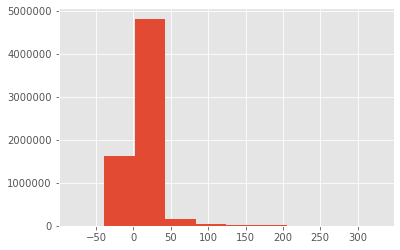

In [264]:
df.price.hist();

There seem to be some items that are priced negatively.

In [265]:
df[df.price < 0]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
105384,2019-10-01 19:10:56,purchase,5716857,1.487580e+18,None,None,-23.81,552507528,dcdd60c6-1a70-442d-bfb2-0252879054ad
185260,2019-10-02 08:30:03,purchase,5716855,1.487580e+18,None,None,-7.94,550375225,5ddec778-9464-4514-914d-be7b751b8e2c
412107,2019-10-03 18:25:39,purchase,5670257,1.487580e+18,None,None,-15.87,556383221,4333d203-bc4d-4d0d-a6e1-0ea3a97a28c1
1172779,2019-10-09 14:49:14,purchase,5716855,1.487580e+18,None,None,-7.94,514562574,fed2aeb4-0c75-44f7-9ca8-1a8be8214779
1286865,2019-10-10 14:33:29,purchase,5716855,1.487580e+18,None,None,-7.94,558797258,a406cf28-f04b-4361-8e6a-c62d36045e07
1366348,2019-10-11 10:27:19,purchase,5716859,1.487580e+18,None,None,-47.62,543647038,85e11d74-6583-4eab-b50c-ff86dbb25d97
1592120,2019-10-13 16:46:01,purchase,5716857,1.487580e+18,None,None,-23.81,559820267,f178c995-f004-4040-b26d-b1cca0f9657d
1710571,2019-10-14 17:33:24,purchase,5716861,1.487580e+18,None,None,-79.37,541122983,b60f777d-afca-4299-8548-273b810d6130
1896796,2019-10-16 11:41:06,purchase,5716857,1.487580e+18,None,None,-23.81,461943726,beefa8fb-a3d1-48ca-97e9-9c95b05ee997
2016222,2019-10-17 11:41:07,purchase,5670257,1.487580e+18,None,None,-15.87,557964596,4f4ee4c7-8081-41f1-91bb-ea74a7f1669d


It looks like each of these events correspond to a customer purchase. These could potentially be returned items. With that in mind, line items with negative purchases will be removed from the dataset.

In [266]:
df = df[df.price > 0]
df.shape

(6660929, 9)

<a id='remove'></a>
### 4. Removed from cart

Next I will look at event types to see what behaviors will be incorporated into the model in order to predict a future purchase.

In [267]:
df.event_type.value_counts()

view                3231603
cart                1997535
remove_from_cart    1007802
purchase             423989
Name: event_type, dtype: int64

The different types of actions captured in the dataset include customer views of each product, adding items to cart, removing items from cart, and purchasing.  

Because my objective is to find customer purchases, I must handle the event types in a way that will not be duplicative. Each action taken by the customer is captured in the data, therefore all rows where a customer purchased a product will also have a row within that same session where the customer added the item to their cart.  

To account for this, counts of occurrences where a customer added an item to their cart should not include sessions where they made a purchase. With this in mind, removals from cart become duplicative and should be removed.

In [268]:
df = df[df.event_type.isin(['view', 'cart', 'purchase'])]
df.shape

(5653127, 9)

<a id='one'></a>
### 5. One-time visitors
One major source of variability in the data I may encounter when predicting future purchases is the presence of one-time visitors. One-time visitors may either buy or leave in their sole visit, which has the potential to throw off the model. Because I am looking to predict the first purchase a user will make, I will need more than one session per user to accurately predict future actions. As such, one-time visitors will be removed from the dataset.

In [269]:
# create dataframe of number of sessions per user, where the user logged more than one session
query = """
SELECT user_id,
       COUNT(DISTINCT user_session)
FROM all_events
GROUP BY 1
HAVING COUNT(DISTINCT user_session) > 1;
"""
one_visit = pd_sql.read_sql(query, connection)
one_visit

,user_id,count
0,1458813,4
1,8846226,2
2,9478445,4
3,9794320,15
4,10280338,6
...,...,...
223972,579956587,2
223973,579956611,3
223974,579960749,2
223975,579963467,2


In [270]:
# filter original dataframe to include only the user IDs found in query
df = df[df.user_id.isin(one_visit.user_id.values)]
df.shape

(4269438, 9)

In [271]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
3,2019-10-01 00:00:07,cart,5881589,2.151191e+18,None,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
4,2019-10-01 00:00:15,cart,5881449,1.487580e+18,None,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
5,2019-10-01 00:00:16,cart,5857269,1.487580e+18,None,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f
6,2019-10-01 00:00:19,cart,5739055,1.487580e+18,None,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733
7,2019-10-01 00:00:24,cart,5825598,1.487580e+18,None,None,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486


### Data Cleaning Summary
1. Include only the first purchase of those that have purchased
2. Remove extraneous product categories (non-cosmetics products)
3. Remove negatively priced items
4. Remove rows with `remove_from_cart`
5. Filter out one-time users

In [272]:
# export cleaned data to create table in Postgres 
# this data table will be what I use for feature egineering
df.to_csv('base_data_cleaned.csv', index=False)

<a id='feature'></a>
## Feature Engineering

### Create Target
The target I am aiming to predict from this dataset is if a customer will make a purchase. The first step is to create a column that turns the "purchase" event into a binary classifier. From there, I can begin engineering other features to predict the event.

In [277]:
# create target column with binary classifier
df['purchased'] = np.where(df['event_type'] == 'purchase', 1, 0)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,purchased
3,2019-10-01 00:00:07,cart,5881589,2.151191e+18,None,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,0
4,2019-10-01 00:00:15,cart,5881449,1.487580e+18,None,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,0
5,2019-10-01 00:00:16,cart,5857269,1.487580e+18,None,runail,2.62,430174032,73dea1e7-664e-43f4-8b30-d32b9d5af04f,0
6,2019-10-01 00:00:19,cart,5739055,1.487580e+18,None,kapous,4.75,377667011,81326ac6-daa4-4f0a-b488-fd0956a78733,0
7,2019-10-01 00:00:24,cart,5825598,1.487580e+18,None,None,0.56,467916806,2f5b5546-b8cb-9ee7-7ecd-84276f8ef486,0


### Create Modeling Dataset
This approach will use features that are "user-centric," meaning each line item will hold values for unique users. Each feature will contain roll-ups of that user's activity throughout the time period in which the data was captured.

In [278]:
# group the original dataframe by user
by_user = df.groupby('user_id', as_index=False).purchased.sum()

In [279]:
# create a column to hold the total number of purchases per user
# change the 'purchased' column to a binary classification
by_user['num_purchases'] = by_user['purchased']
by_user['purchased'] = (by_user['purchased'] >= 1).astype(int)
by_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221069 entries, 0 to 221068
Data columns (total 3 columns):
user_id          221069 non-null int64
purchased        221069 non-null int64
num_purchases    221069 non-null int64
dtypes: int64(3)
memory usage: 6.7 MB


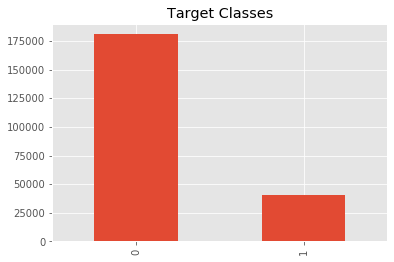

In [280]:
# visualize feature classes to assess if there is imbalance
by_user.purchased.value_counts().plot(kind='bar')
plt.title('Target Classes');

Whoa. The result set is highly skewed with more users that have not purchased, which is in line with what I'd expect for e-commerce data within this window. I will have to take this into account when testing classification methods by stratifying the prediction and over/undersampling.

### Recency, Frequency, Monetary Value
Recency, frequency, and monetary value, commonly known as RFM, is a widely used metric in marketing analytics. This metric aims to group individual users into user segments, or cohorts, based on three factors:
1. **Recency** - The last time the user made a purchase in the store. Since I am aiming to gauge future purchases based on behavior, I am adjusting this metric to reflect the last time the user made an action on the site. This value is represented as the number of days between the current date and the date of the last user action.
2. **Frequency** - How many times the user made a purchase in a given window. Again, I will adjust this metric to include the number of actions taken rather than the number of purchases to better predict future purchases based on all behavior. 
3. **Monetary value** - The total dollar amount of all purchases made by the user. Similar to the other components, the typical RFM calculation will not work here, as we do not know whether the customer has made a purchase or not. To account for this, this value will measure the total value of products the customer has added to their cart.

In [281]:
# run sql query that calculates RFM scores and create dataframe
query = """
WITH monetary_value_calc AS (
    SELECT user_id,
           AVG(product_value) AS monetary_value
    FROM (
         SELECT user_id,
                user_session,
                SUM(price) AS product_value
        FROM base_data_cleaned
        WHERE event_type != 'purchase'
        GROUP BY 1, 2) AS total_value
    GROUP BY 1
),
rfm_raw AS (
    SELECT base_data_cleaned.user_id,
           EXTRACT(DAY FROM CURRENT_DATE - MAX(event_time)) AS recency,
           COUNT(DISTINCT user_session) AS frequency,
           COALESCE(AVG(monetary_value), 0) AS monetary_value
    FROM base_data_cleaned
    LEFT JOIN monetary_value_calc
        ON base_data_cleaned.user_id = monetary_value_calc.user_id
    GROUP BY 1
),
rfm_scores AS (
    SELECT rfm_raw.user_id,
           NTILE(5) OVER(ORDER BY recency) AS r,
           NTILE(5) OVER(ORDER BY frequency) AS f,
           NTILE(5) OVER(ORDER BY monetary_value) AS m
    FROM base_data_cleaned
    JOIN rfm_raw
    ON base_data_cleaned.user_id = rfm_raw.user_id
)

SELECT DISTINCT user_id,
                rfm_raw.recency,
                rfm_raw.frequency,
                ROUND(rfm_raw.monetary_value, 2) AS monetary_value,
                r,
                f,
                m,
                CONCAT(r, f, m) AS rfm_score,
                CAST(CONCAT(r, f, m) AS INT) AS rfm_int
FROM rfm_raw
JOIN rfm_scores
USING(user_id);
"""
rfm = pd_sql.read_sql(query, connection)

Note that for this query I took a few different cuts of the rfm calculation. I did this in order to test different combinations in the model, I'm not sure which will play nice.

In [282]:
print(rfm.shape)
rfm.head()

(221132, 9)


,user_id,recency,frequency,monetary_value,r,f,m,rfm_score,rfm_int
0,1458813,81.0,4,39.84,2,2,3,223,223
1,8846226,131.0,2,63.46,5,1,4,514,514
2,9478445,94.0,4,11.31,3,3,1,331,331
3,9794320,77.0,11,26.42,2,4,2,242,242
4,10280338,82.0,3,143.30,2,2,5,225,225


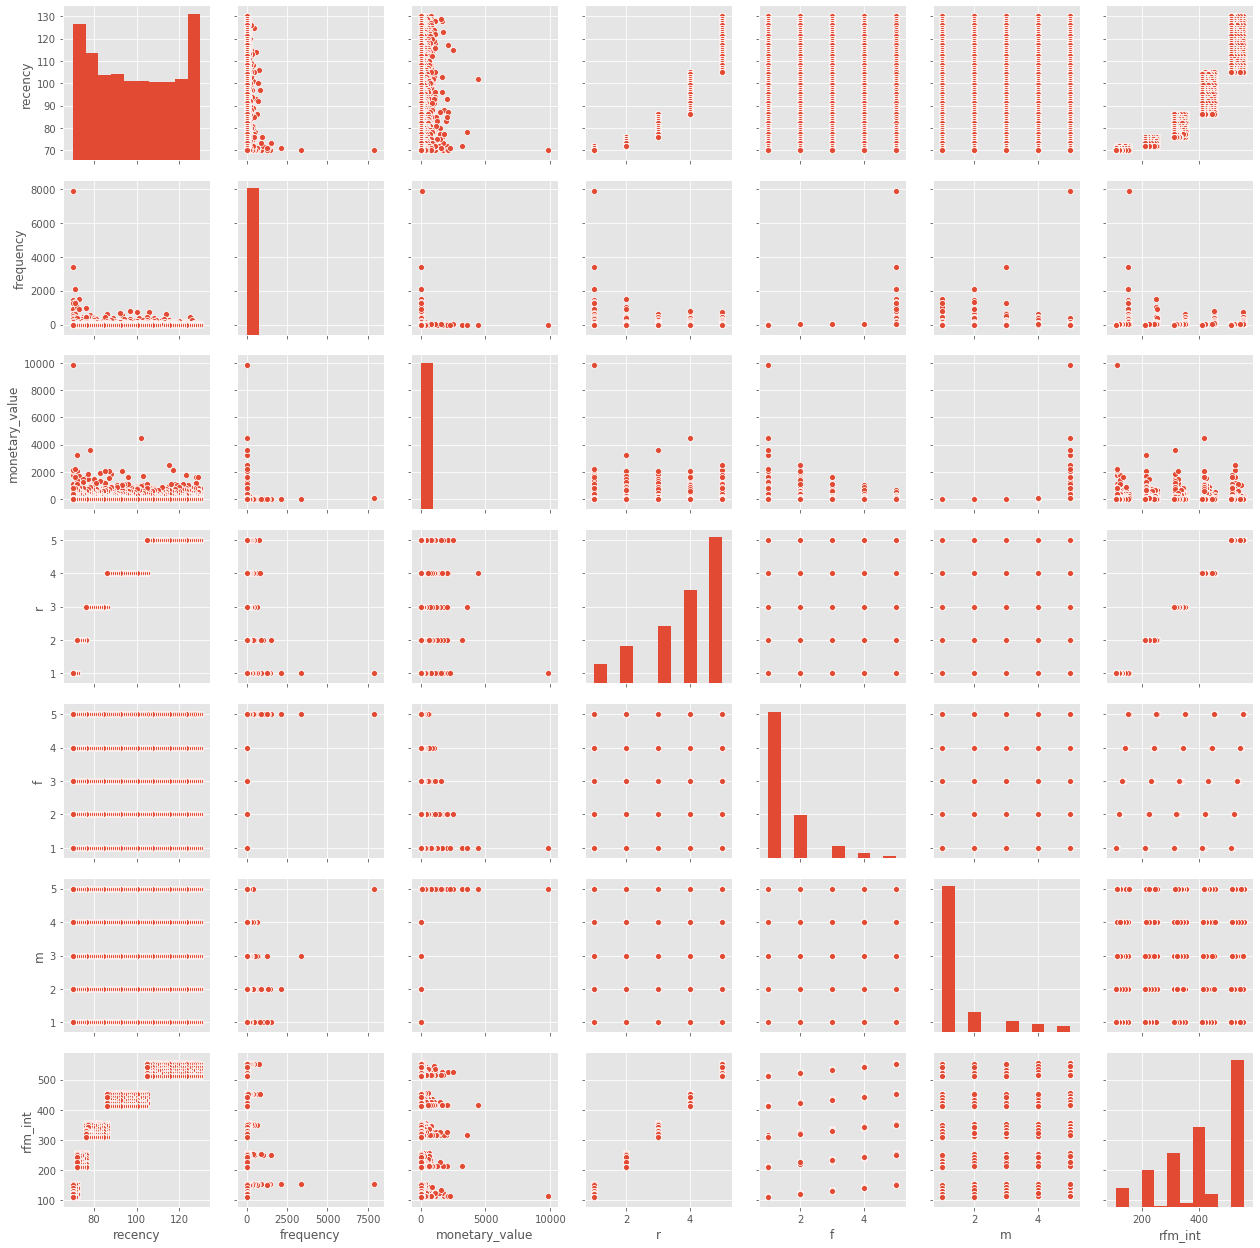

In [121]:
# view distribution of features
sns.pairplot(rfm.drop(['user_id', 'rfm_score', 'rfm_int'], axis=1));

In [283]:
# view descriptive statistics of features
rfm['recency'].describe(), rfm['frequency'].describe(), rfm['monetary_value'].describe()

(count    221132.000000
 mean         96.896085
 std          18.005230
 min          72.000000
 25%          80.000000
 50%          95.000000
 75%         112.000000
 max         132.000000
 Name: recency, dtype: float64, count    221132.000000
 mean          4.851767
 std          17.460941
 min           1.000000
 25%           2.000000
 50%           2.000000
 75%           4.000000
 max        5710.000000
 Name: frequency, dtype: float64, count    221132.000000
 mean         39.880046
 std          73.066406
 min           0.000000
 25%           7.140000
 50%          17.150000
 75%          44.290000
 max        3093.070000
 Name: monetary_value, dtype: float64)

Aha! It looks like frequency and monetary_value are pretty highly skewed. These show that most customers visit the store pretty infrequenty, my hunch would be maybe 2 to 3 times within the given time period (since we removed one-time customers). The skew in monetary value makes sense because a lot of customers have never added anything to their cart. We filled these nulls with zero, so naturally the data will skew towards zero.

To account for these extreme values, I will need to scale the features. A log transform will not work here because the minimum value is zero in the monetary value column, since there are customers that have not added any items to their cart.

BUT WAIT: In that query to pull those values I binned each feature into quantiles. What I actually did here is a method known as <font color='red'>discretization</font>, which is a form of standardization. Passing these values, whether separate features or the combined integer value of the segments, effecively normalize the calculation.

In [284]:
# combine target column to features to color plot
target = by_user[['user_id', 'purchased']]
rfm_with_pred = rfm.merge(target, on='user_id')

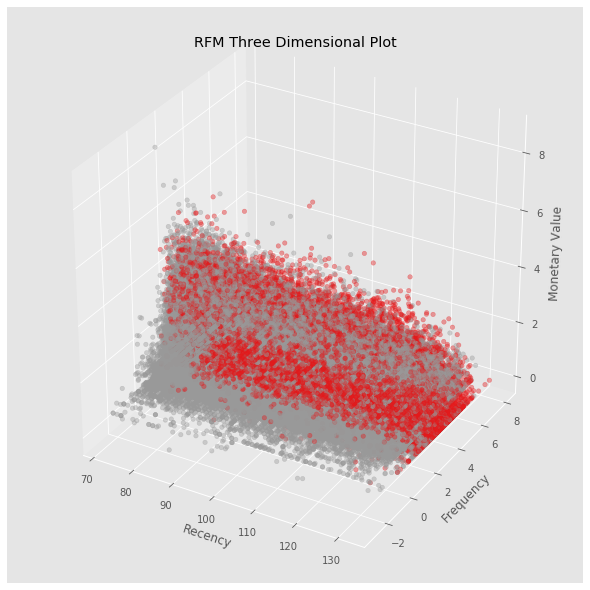

In [287]:
# create axes to plot the values
# plot frequency and monetary value on log scales to better show distribution of points
r = rfm_with_pred['recency']
f = np.log(rfm_with_pred['frequency'])
m = np.log(rfm_with_pred['monetary_value'])
c = rfm_with_pred['purchased'] == 0

# plot 3d figure of rfm cohorts
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)

ax.scatter(r, m, f, c=c, cmap='Set1', alpha=0.4)
ax.set_title('RFM Three Dimensional Plot')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value');

### Actions per user
Calculate the number of each unique action per user; product views and adds to cart. The total number of purchases was already created when grouping by user, so this step will focus on creating features to quantify the other types of action.

In [288]:
query = """
SELECT user_id,
       SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS num_views,
       SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS adds_to_cart
FROM base_data_cleaned
GROUP BY 1;
"""
actions = pd_sql.read_sql(query, connection)

In [289]:
actions.head()

,user_id,num_views,adds_to_cart
0,1458813,29,0
1,8846226,7,24
2,9478445,4,0
3,9794320,65,46
4,10280338,40,36


### Add to cart rate
This feature is the measure of how often a customer added a product to their cart when they visited the store. This is a measure of customer intent and may be an indicator of future purchasing.

In [290]:
query = """
WITH cart_sessions AS (
    SELECT base_data_cleaned.user_id,
           add_to_cart_sessions,
           COUNT(user_session) AS total_sessions
    FROM base_data_cleaned
    JOIN (
        SELECT user_id,
               COUNT(user_session) add_to_cart_sessions
        FROM base_data_cleaned
        WHERE event_type = 'cart'
        GROUP BY 1) AS adds_to_cart
        ON base_data_cleaned.user_id = adds_to_cart.user_id
    GROUP BY 1, 2
)

SELECT user_id,
       CASE WHEN total_sessions = 0 THEN 0 ELSE
           ROUND(CAST(add_to_cart_sessions AS decimal) / total_sessions, 2) END AS add_to_cart_rate
FROM cart_sessions;
"""
add_to_cart = pd_sql.read_sql(query, connection)

In [291]:
add_to_cart.head()

,user_id,add_to_cart_rate
0,8846226,0.77
1,9794320,0.40
2,10280338,0.42
3,10968431,0.33
4,11274156,0.33


### Brand segmentation
Segmentation by brand may give insight into particular affinities for each customer. 
To model this in the data, I will create features for each brand based on each user's individual percentage of total views and percentage of total adds to cart for each brand. These features alongside the users' total views and adds to cart may give the model insight into particular thresholds for brand affinity that entices a customer to eventually make a purchase.

In [292]:
query = """
WITH brand_totals AS (
    SELECT user_id,
           COALESCE(brand, 'other') AS brand,
           SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS num_views_per_brand,
           SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS num_carts_per_brand
    FROM base_data_cleaned
    GROUP BY 1, 2
),
user_totals AS (
    SELECT DISTINCT user_id,
                    COALESCE(brand, 'other') AS brand,
                    SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) OVER(PARTITION BY user_id) AS user_views,
                    SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) OVER(PARTITION BY user_id) AS user_carts
    FROM base_data_cleaned
)

SELECT brand_totals.user_id,
       brand_totals.brand,
       CASE WHEN user_views = 0 THEN 0 ELSE
           ROUND(CAST(num_views_per_brand AS decimal) / user_views, 2) END AS perc_user_views,
       CASE WHEN user_carts = 0 THEN 0 ELSE
           ROUND(CAST(num_carts_per_brand AS decimal) / user_carts, 2) END AS perc_user_carts
FROM brand_totals
JOIN user_totals
    USING(user_id, brand);
"""
brand_dist = pd_sql.read_sql(query, connection)

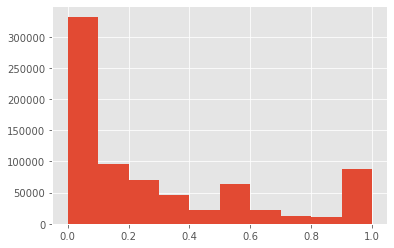

In [293]:
brand_dist.perc_user_views.hist();

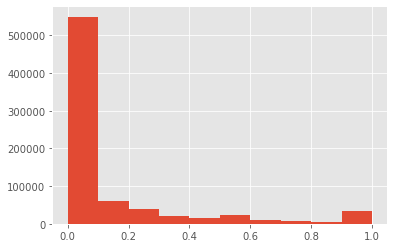

In [294]:
brand_dist.perc_user_carts.hist();

In [295]:
brand_dist.head()

,user_id,brand,perc_user_views,perc_user_carts
0,1458813,f.o.x,0.72,0.00
1,8846226,kapous,0.14,0.29
2,10280338,other,0.05,0.11
3,13392135,cosmoprofi,0.21,0.33
4,13392135,other,0.29,0.44


In [296]:
# group by user_id and brand in order to unstack index and get individual columns per brand
group_user_categories = brand_dist.groupby(['user_id', 'brand']).mean()

In [297]:
# unstack the dataframe and create separate columns for each brand; fill nulls with zero
brand_unstack = group_user_categories.unstack(level=-1).fillna(0)

In [298]:
# user a list comprehension to create unique feature names for each brand + metric
brand_unstack.columns = ['_'.join(col) for col in brand_unstack.columns]

In [299]:
# drop the "other" category columns in the perc_user_views and perc_user_charts
brand_metrics = brand_unstack.drop(['perc_user_views_other', 'perc_user_carts_other'], axis=1)

In [300]:
brand_metrics.head()

,perc_user_views_airnails,perc_user_views_almea,perc_user_views_andrea,perc_user_views_ardell,perc_user_views_art-visage,perc_user_views_artex,perc_user_views_aura,perc_user_views_australis,perc_user_views_balbcare,perc_user_views_barbie,...,perc_user_carts_vilenta,perc_user_carts_vl-gel,perc_user_carts_vosev,perc_user_carts_weaver,perc_user_carts_yoko,perc_user_carts_ypsed,perc_user_carts_yu-r,perc_user_carts_zab,perc_user_carts_zeitun,perc_user_carts_zinger
user_id,,,,,,,,,,,,,,,,,,,,,
1458813,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8846226,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9478445,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9794320,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10280338,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now this is quite a bit of features, but what if this is all noise? What if the brand itself that drew the attention of each customer didn't matter at all, rather the fact that the customer directed attention toward any brand in the fashion that they did. To simulate this and roll up the data, I will also include a single value for the percent of views and the percent of adds to cart for each customer that takes the maximum value for each customer from the distribution of brands.

In [301]:
max_vals = brand_dist.groupby('user_id', as_index=False).max()

In [302]:
# drop the brand columns
max_vals = max_vals.drop('brand', axis=1)

In [303]:
# rename the columns to avoid confusion with brand columns created from metrics
max_vals = max_vals.rename(columns={'perc_user_views': 'max_perc_user_views', 'perc_user_carts': 'max_perc_user_carts'})
max_vals.head()

,user_id,max_perc_user_views,max_perc_user_carts
0,1458813,0.72,0.00
1,8846226,0.57,0.33
2,9478445,0.50,0.00
3,9794320,0.80,0.63
4,10280338,0.50,0.44


Now the dataset will include a measure of a customers' affinity to view or add products to cart of particular brands. Let's see how this impacts the overall classification of each customer.

### Time-based components
To introduce a time-based component to the model, I will create a feature that measures the average number of days between customer visits as well as the total range in days between first and last visit. The goal here is to create metrics that provide insight into customer intent. Does a customer that visits the store more frequently suggest they will soon make a purchase. This used in conjunction with the frequency metric, which represents the total number of sessions the customer logged, may tell that story in the model.

In [313]:
query = """
SELECT user_id,
       EXTRACT(DAY FROM (MAX(event_time) - MIN(event_time))) AS range_visits,
       ROUND(CAST(EXTRACT(DAY FROM (MAX(event_time) - MIN(event_time))) /
                  COUNT(DISTINCT user_session) AS decimal), 2) AS avg_days_btw_sessions
FROM base_data_cleaned
GROUP BY 1;
"""
time_based = pd_sql.read_sql(query, connection)

In [314]:
time_based.head()

,user_id,range_visits,avg_days_btw_sessions
0,1458813,1.0,0.25
1,8846226,0.0,0.00
2,9478445,0.0,0.00
3,9794320,54.0,4.91
4,10280338,30.0,10.00


### Average price of products viewed and added to cart
To gain further insight into customer affinity toward different pricing tiers, I will segment pricing by products viewed and added to cart per user

In [340]:
query = """
WITH view_price AS (
    SELECT user_id,
           AVG(price) AS avg_view_price
    FROM base_data_cleaned
    WHERE event_type = 'view'
    GROUP BY 1
),
cart_price AS (
    SELECT user_id,
           AVG(price) AS avg_cart_price
    FROM base_data_cleaned
    WHERE event_type = 'cart'
    GROUP BY 1
)

SELECT user_id,
       ROUND(avg_view_price, 2) AS avg_view_price,
       ROUND(COALESCE(avg_cart_price, 0), 2) AS avg_cart_price
FROM view_price
LEFT JOIN cart_price
USING(user_id);
"""
avg_price = pd_sql.read_sql(query, connection)

In [341]:
avg_price.head()

,user_id,avg_view_price,avg_cart_price
0,1458813,5.50,0.00
1,10280338,6.05,5.22
2,13392135,5.81,5.45
3,14297993,12.87,6.62
4,15781728,3.73,3.47


<a id='export'></a>
## Merge DataFrames and Export
Merge dataframes created with new features to the original, grouped dataframe. Export the resulting dataframe as the dataset to run models for classification.

In [342]:
# merge rfm scores onto grouped dataframe
users = by_user.merge(rfm, on='user_id')

In [343]:
# merge user actions data
users = users.merge(actions, on='user_id')

In [344]:
# merge add to cart rate data
users = users.merge(add_to_cart, how='left', on='user_id')

In [345]:
# merge brand segmentation metrics to create final modeling set
# users = users.merge(brand_metrics, how='left', on='user_id')

In [346]:
users = users.merge(max_vals, how='left', on='user_id')

In [347]:
users = users.merge(time_based, on='user_id')

In [348]:
users = users.merge(avg_price, on='user_id')

The percentage metrics (add to cart rate, user views %, and add to cart %) produced nulls due to the left joins in order to preserve customers that may not have added to their cart. To reflect the customers' that did not add to their cart, I will fill all null values with zero. 

In [349]:
# fill null values with zero
users = users.fillna(0)

Finally, I will need to drop the number of purchases metric to prevent data leakage in my models.

In [350]:
users = users.drop('num_purchases', axis=1)

In [351]:
print(users.shape)
users.head()

(217743, 19)


,user_id,purchased,recency,frequency,monetary_value,r,f,m,rfm_score,rfm_int,num_views,adds_to_cart,add_to_cart_rate,max_perc_user_views,max_perc_user_carts,range_visits,avg_days_btw_sessions,avg_view_price,avg_cart_price
0,1458813,0,81.0,4,39.84,2,2,3,223,223,29,0,0.00,0.72,0.00,1.0,0.25,5.50,0.00
1,8846226,0,131.0,2,63.46,5,1,4,514,514,7,24,0.77,0.57,0.33,0.0,0.00,5.63,3.65
2,9478445,0,94.0,4,11.31,3,3,1,331,331,4,0,0.00,0.50,0.00,0.0,0.00,11.31,0.00
3,9794320,1,77.0,11,26.42,2,4,2,242,242,65,46,0.40,0.80,0.63,54.0,4.91,2.99,2.10
4,10280338,1,82.0,3,143.30,2,2,5,225,225,40,36,0.42,0.50,0.44,30.0,10.00,6.05,5.22


In [352]:
# export dataframe to pickle file to easily import in modeling notebook
with open('modeling_data.pickle', 'wb') as outfile:
    pickle.dump(users, outfile)